In [ ]:
from google.colab import files
files.upload()  # Unggah file kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"siwiyulindaa","key":"ad78ca7a19317ebd2f03ea7fd99677ba"}'}

In [ ]:
# Membuat direktori .kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Mengunduh dataset dari Kaggle
!kaggle datasets download -d syedalinaqvi/augmented-skin-conditions-image-dataset -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset
License(s): CC-BY-SA-4.0
 96% 263M/273M [00:02<00:00, 95.8MB/s]
100% 273M/273M [00:02<00:00, 106MB/s] 


In [ ]:
# Ekstraksi dataset
import zipfile
with zipfile.ZipFile('/content/dataset/augmented-skin-conditions-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


In [ ]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 47.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import matplotlib.pyplot as plt

In [ ]:
# 3. Load and Preprocess Dataset
dataset_path = '/content/dataset/Skin_Conditions'  # Update this if dataset structure changes

In [ ]:
# Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 2394 files belonging to 6 classes.


In [ ]:
# Class names
class_names = dataset.class_names
print("Detected Classes:", class_names)

Detected Classes: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']


In [ ]:
# Split dataset
def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)

    train_dataset = dataset.take(train_end)
    val_dataset = dataset.skip(train_end).take(val_end - train_end)
    test_dataset = dataset.skip(val_end)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Augmentasi dataset
def augment_data(dataset):
    def augment(image, label):
        image = data_augmentation(image)
        return image, label

    return dataset.map(augment)

train_dataset = augment_data(train_dataset)

In [ ]:
# 4. Load model dengan VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

model = Sequential([
    base_model,  # Tambahkan base model sebagai lapisan pertama
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Layer klasifikasi
])

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# 5. Train the Model
# Callback untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Simpan model terbaik
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Melatih model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 649ms/step - accuracy: 0.7126 - loss: 0.7824 - val_accuracy: 0.7634 - val_loss: 0.6354
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 596ms/step - accuracy: 0.7460 - loss: 0.7250 - val_accuracy: 0.8125 - val_loss: 0.5916
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 579ms/step - accuracy: 0.7282 - loss: 0.7143 - val_accuracy: 0.8170 - val_loss: 0.5475
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 590ms/step - accuracy: 0.7474 - loss: 0.6943 - val_accuracy: 0.7857 - val_loss: 0.5973
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 609ms/step - accuracy: 0.7394 - loss: 0.7328 - val_accuracy: 0.8393 - val_loss: 0.4991
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 598ms/step - accuracy: 0.7522 - loss: 0.6765 - val_accuracy: 0.7812 - val_loss: 0.6300
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 585ms/step - accuracy: 0.7636 - loss: 0.6763 - val_accuracy: 0.8348 - val_loss: 0.4663
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 604ms/step - accuracy: 0.7546 - loss: 0.6652 - val_accu

In [ ]:
# 6. Evaluate the Model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8151 - loss: 0.4922
Test Accuracy: 0.8160


In [ ]:
# fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-5]:  # Hanya fine-tune 5 layer terakhir
    layer.trainable = False

# Compile ulang model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune model
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 763ms/step - accuracy: 0.8036 - loss: 0.5893 - val_accuracy: 0.8170 - val_loss: 0.4706
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 647ms/step - accuracy: 0.8356 - loss: 0.4667 - val_accuracy: 0.8705 - val_loss: 0.3942
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 650ms/step - accuracy: 0.8536 - loss: 0.4127 - val_accuracy: 0.8661 - val_loss: 0.4003
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 702ms/step - accuracy: 0.8473 - loss: 0.3970 - val_accuracy: 0.8929 - val_loss: 0.3473
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 622ms/step - accuracy: 0.8602 - loss: 0.3839 - val_accuracy: 0.8795 - val_loss: 0.3978
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 645ms/step - accuracy: 0.8734 - loss: 0.3357 - val_accuracy: 0.9196 - val_loss: 0.2734
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 628ms/step - accuracy: 0.9066 - loss: 0.2623 - val_accuracy: 0.9196 - val_loss: 0.2603
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 650ms/step - accuracy: 0.9021 - loss: 0.2623 - val_accu

In [ ]:
# Evaluasi ulang
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy After Fine-Tuning: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 253ms/step - accuracy: 0.8905 - loss: 0.3385
Test Accuracy After Fine-Tuning: 0.9040


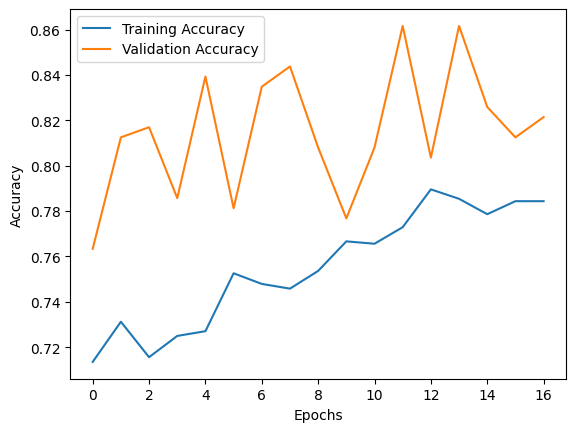

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


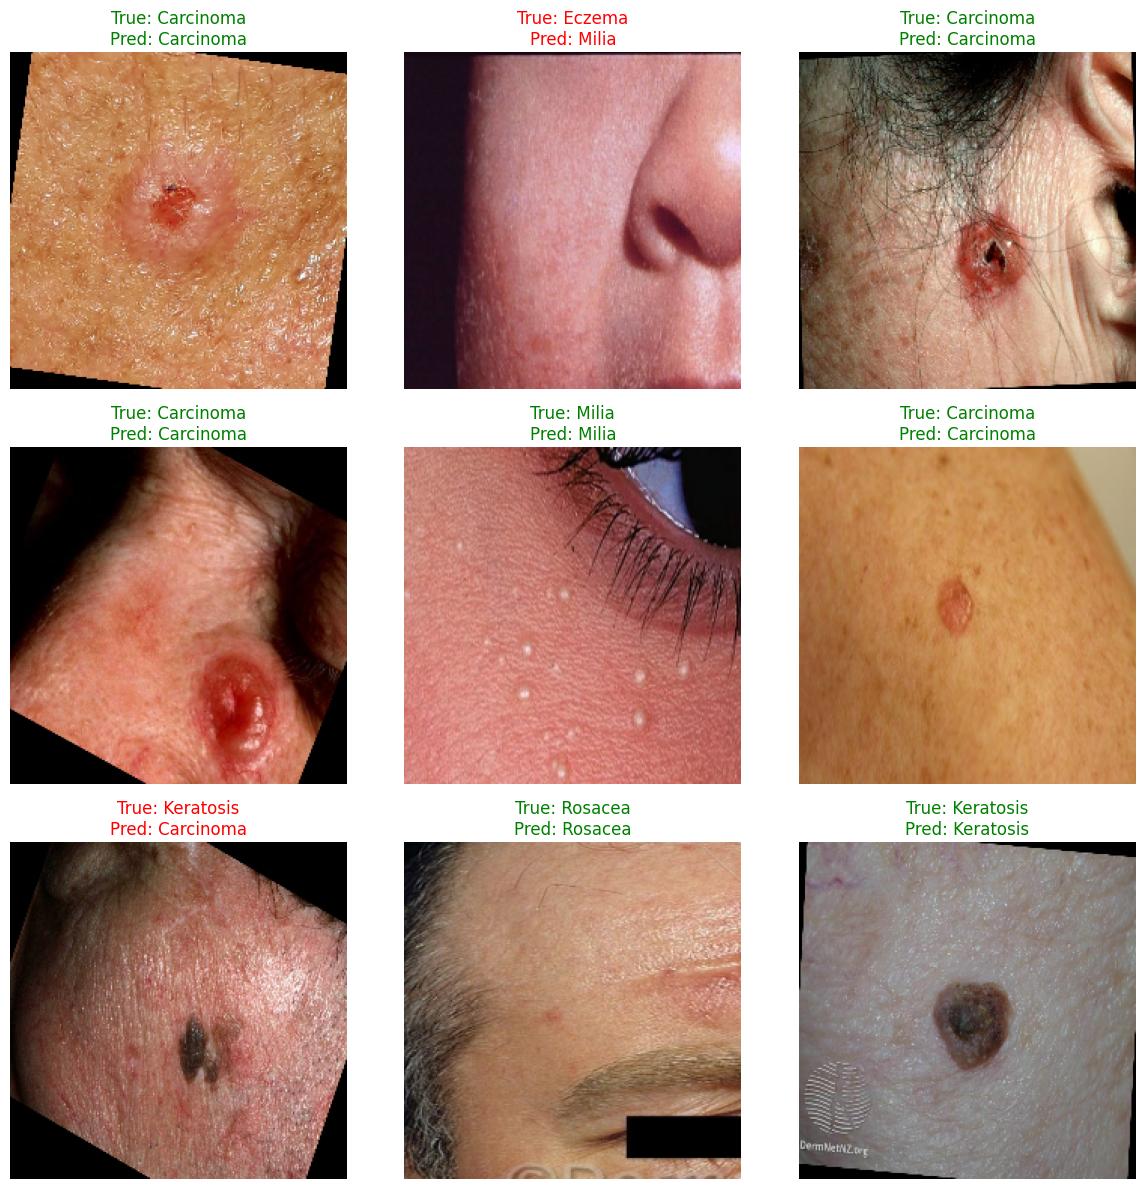

In [ ]:
# Plot akurasi training dan validasi
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(history)

# Visualisasi hasil prediksi pada test dataset
def plot_random_images(test_dataset, model, class_names, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for image_batch, label_batch in test_dataset.take(1):
        predictions = model.predict(image_batch)
        predicted_labels = tf.argmax(predictions, axis=1)
        indices = np.random.choice(len(image_batch), num_images, replace=False)

        for idx, ax in enumerate(axes):
            img = image_batch[indices[idx]].numpy().astype(np.uint8)
            true_label = label_batch[indices[idx]].numpy()
            pred_label = predicted_labels[indices[idx]]

            ax.imshow(img)
            ax.axis('off')

            true_label_name = class_names[true_label]
            pred_label_name = class_names[pred_label]
            title_color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color=title_color, fontsize=12)

    plt.tight_layout()
    plt.show()

plot_random_images(test_dataset, model, class_names)

In [ ]:
model.save("model.h5")

In [ ]:
# mengubah model.h5 kedalam bentuk json
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-12-06 04:51:38.823389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733460698.844050   15889 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733460698.852552   15889 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
import tensorflow as tf

# Path output untuk menyimpan model TFLite
tflite_model_path = "/content/model.tflite"

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Opsional) Menambahkan optimasi agar model lebih kecil
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Konversi ke TFLite
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi ke format TFLite di: {tflite_model_path}")

Saved artifact at '/tmp/tmpzw635nt_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_156')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  137321032825168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321032820768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321032822704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321032821120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321032819712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321033757824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321033755536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321033175760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321033179984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137321033176816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1373210331